# Multi-class Image Classification

> Add blockquote



We've just been through a bunch of the following steps with a binary classification problem (pizza vs. steak), now we're going to step things up a notch with 10 classes of food (multi-class classification).

1. Becode one with the data
2. Preprocess the dta (get it ready for a model)
3. Create a model (start with a baseline)
4. Fit the model (overfit it to make sure it works)
5. Evaluate the model
6. Adjust different typerparameters and improve the model (try to beat baseline/reduce overfitting)
7. Repeat until satisfied


In [12]:
## 0. General Functions

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Let's visualize our images
def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

## 1. Import and become one with the data

Dataset link: https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Miror   link: https://drive.google.com/uc?export=download&id=1IC6tifXrO4tVEpethHFimte1XRV8o35s

In [ ]:
# Downlaod via original link:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

In [6]:
# Donwload via mirorred link
!pip install gdown

import gdown

# Google Drive file ID
file_id = "1IC6tifXrO4tVEpethHFimte1XRV8o35s"
url = f"https://drive.google.com/uc?id={file_id}"

# Download and save as zip
output = "10_food_classes_all_data.zip"
gdown.download(url, output, quiet=False)

print("Download completed!")

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Downloading...
From (original): https://drive.google.com/uc?id=1IC6tifXrO4tVEpethHFimte1XRV8o35s
From (redirected): https://drive.google.com/uc?id=1IC6tifXrO4tVEpethHFimte1XRV8o35s&confirm=t&uuid=4368f7e0-72fe-4cba-81c2-daa4f576bdfb
To: /home/jovyan/10_food_classes_all_data.zip
100% 519M/519M [01:11<00:00, 7.23MB/s] 

Download completed!


In [7]:
import zipfile

# Unzip our data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [8]:
import os

# Walk through 10 classes of food image data
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_all_data'
There are 10 directories and 0 images in '10_food_classes_all_data/test'
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'
There are 10 directori

In [9]:
!ls 10_food_classes_all_data

test  train


In [10]:
# Setup the train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [11]:
# Let's get the class names
import pathlib
import numpy as np

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image shape: (512, 512, 3)


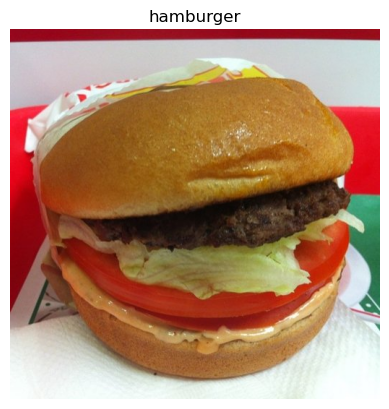

In [13]:
# Visualize, visualize, visualize
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

### 2. Preprocess the data (prepare it for a model)

In [15]:
# Create train and test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode="categorical")

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### 3. Create a model (start with a baseline)

In [16]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [20]:
# Create our model (very similar to previous model but actually the same as CNN explorer)
model_8 = Sequential([
    Input(shape=(224, 224, 3)),        # input layer (specify input shape)
    Conv2D(10, 3, activation=relu),
    Conv2D(10, 3, activation=relu),
    MaxPool2D(),
    Conv2D(10, 3, activation=relu),
    Conv2D(10, 3, activation=relu),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation=softmax)
])

In [22]:
# Compile the model
model_8.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

### 4. Fit a model

In [23]:
# Fit the model
history_8 = model_8.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1757755132.504610    3796 service.cc:148] XLA service 0x730ae00044a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757755132.506814    3796 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-09-13 09:18:52.702214: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757755133.097427    3796 cuda_dnn.cc:529] Loaded cuDNN version 90501


  1/235 ━━━━━━━━━━━━━━━━━━━━ 32:56 8s/step - accuracy: 0.0312 - loss: 2.3373

I0000 00:00:1757755139.184531    3796 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 44s 151ms/step - accuracy: 0.1735 - loss: 2.2090 - val_accuracy: 0.2336 - val_loss: 2.0696
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 30s 128ms/step - accuracy: 0.3256 - loss: 1.9194 - val_accuracy: 0.3588 - val_loss: 1.8268
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 138ms/step - accuracy: 0.5113 - loss: 1.4771 - val_accuracy: 0.3420 - val_loss: 1.9233
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 33s 139ms/step - accuracy: 0.7320 - loss: 0.8573 - val_accuracy: 0.3056 - val_loss: 2.4601
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - accuracy: 0.9113 - loss: 0.3301 - val_accuracy: 0.2752 - val_loss: 3.6628


In [24]:
model_8.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28090)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │       280,910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 851,762 (3.25 MB)

 Trainable params: 283,920 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 567,842 (2.17 MB)